In [1]:
%load_ext autoreload
%autoreload 2

import scraper
import pickle
from itertools import groupby, chain, product
from collections import deque
import numpy as np
from scipy.stats import t
import numba
import matplotlib.pyplot as plt
%matplotlib notebook

class Team:
    def __init__(self, abrev, full):
        self.abrev = abrev
        self.full = full

Creating a player whose shots are correlated

In [2]:
def dice(n):
    """ Produces make(1)/miss(0) for shooter who makes are correlated and misses are correlated."""
    out = np.zeros(n).astype("int32")
    probs = np.random.rand(n)
    last = -1
    for i in range(n):
        if last == 1:
            cut = .7
        elif last == 0:
            cut = .3
        else:
            cut = .5
        if probs[i] < cut:
            last = 1
        else:
            last = 0
        out[i] = last
    return out

Getting roster,  game-IDs, and the full score records (in a single season) for players on a team.

All data is scraped off of [http://espn.go.com/nba/](http://espn.go.com/nba/)

In [3]:
spurs = Team("sa", "San Antonio Spurs")  # I need to automate the lookup for team abbreviation
spurs.roster = scraper.get_roster(spurs.abrev, spurs.full)  # only grabs latest roster...
spurs.game_ids = scraper.get_game_ids(spurs.abrev, spurs.full, end_year=2016)  #
sa_scoring_record = {"team": []}
sa_scoring_record.update((player, []) for player in spurs.roster)

In [4]:
def get_scoring_record(team):
    """ Parameters
        ----------
        team: this_notebook.Team
        
        Returns
        -------
        Dict[str, List[List[int], ...]
            Maps player name to a list of score-sequence lists, one list for each game
            in the regular and post season. An empty list means the player did not take 
            any shots (or didn't play).
            
        Notes
        -----
        Scores are (+/-){1, 2, 3}. - <-> miss, + <-> make"""
    scoring_record = {"team": []}
    scoring_record.update((player, []) for player in team.roster)
    for game_id in team.game_ids["regular"] + team.game_ids["post"]:
        for player in scoring_record:
            scoring_record[player].append([])
        scores = scraper.get_game_data(game_id, team.abrev)
        for player, seq in scores.items():
            try:
                scoring_record[player][-1].extend(seq)
            except KeyError:  # player is not on roster
                pass
    return scoring_record

In [5]:
try:
    with open("spurs.pkl", "rb") as infile:
        spurs = pickle.load(infile)
except (FileNotFoundError, EOFError):
    spurs.scoring_record = get_scoring_record(spurs) # this takes a while to complete
    with open("spurs.pkl", "wb") as outfile:
        pickle.dump(spurs, outfile)

Generating a player's full make-miss sequence, for a given range of point attempts (e.g. 3's only, or both 1's & 2's, etc). And extracting all make/miss streaks within.

In [6]:
def make_miss_sequence(player, record, low=1, high=4):
    """ Returns a binary (miss:0, make:1) sequence of player's make-miss history
        over all games. Disregarding point-attempts falling outside of [low, high).
        
        Examples
        --------
        # Tim Duncan's make-miss temporal sequence for 2-pointers only 
        make_miss_sequence("Tim Duncan", spurs.scoring_record, low=2, high=3)
        """
    assert low <= 3
    assert 1 < high
    assert low < high

    rec = chain.from_iterable(record[player])  # flatten scoring sequences across games into one sequential iterable
    make_miss = []
    for i in rec:
        if low <= abs(i) < high:
            make_miss.append(1 if i > 0 else 0)
    return np.array(make_miss, dtype="int32")

In [7]:
def make_miss_bunch(_make_miss_sequence):
    """ Returns all make/miss streak lengths
    
        Parameters
        ----------
        _make_miss_sequence: List[int]
            Binary make-miss sequence for a player.
        Returns
        -------
        out: Dict[int, List[int]]
            out[0] -> list of miss-streak-lengths
            out[1] -> list of make-streak-lengths"""
    out = {0:[], 1:[]}
    for k, g in groupby(_make_miss_sequence):
        out[k].append(sum(1 for _ in g))
    return out

Comparing player make/miss streak lengths against that of a Bernoulli trial with the same probabi

In [8]:
def compare_bunches(player_make_miss, name=None):
    avg = np.mean(player_make_miss)
    out = make_miss_bunch(player_make_miss)

    p = avg
    avg_make_bunch = 1/(1 - p)
    avg_miss_bunch = 1/p
    print(name)
    print("Shot avg {:.2f}\n".format(avg))
    print("miss bunch size:\n random {:.2f}, player {:.2f}".format(avg_miss_bunch, np.mean(out[0])))
    print(" relative difference: {:.2f}%".format( 100*(np.mean(out[0]) - avg_miss_bunch)/avg_miss_bunch ) )
    print('\n')
    print("make bunch size:\n random {:.2f}, player {:.2f}".format(1/(1-avg), np.mean(out[1])))
    print(" relative difference: {:.2f}%".format( 100*(np.mean(out[1]) - avg_make_bunch)/avg_make_bunch ))
    print("\n*********")

In [9]:
name = "Tim Duncan"
team = spurs
low = 2
high = 3 
player_make_miss = make_miss_sequence(name, spurs.scoring_record, low, high)
compare_bunches(player_make_miss, name)
compare_bunches(dice(10000), "Correlated Shooter")

Tim Duncan
Shot avg 0.53

miss bunch size:
 random 1.88, player 2.05
 relative difference: 9.05%


make bunch size:
 random 2.13, player 2.33
 relative difference: 9.05%

*********
Correlated Shooter
Shot avg 0.50

miss bunch size:
 random 1.98, player 3.26
 relative difference: 64.57%


make bunch size:
 random 2.02, player 3.32
 relative difference: 64.57%

*********


Looking at correlation functions

In [10]:
@numba.jit("float64[:](float64[:], int32)")
def autocorr_kernel(data, max_window):
    out = np.zeros(max_window, dtype="float64")
    for t in range(max_window):
        for i in range(data.size - max_window):
            out[t] += data[i]*data[i+t]
    return out
            
def autocorr(data, max_window):
    assert isinstance(max_window, int)
    assert 0 < max_window < data.size
    data = data - np.mean(data)
    out = autocorr_kernel(data.astype("float64"), max_window)
    out /= data.size - max_window
    return out

<IPython.core.display.Javascript object>


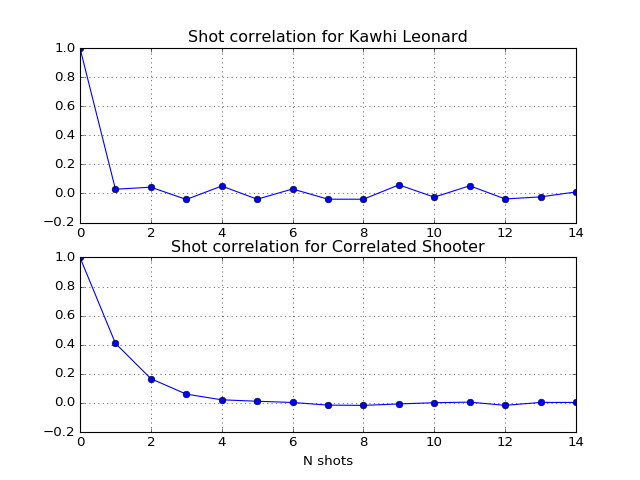

In [11]:
name = "Kawhi Leonard"
team = spurs
low = 3
high = 4 
player_make_miss = make_miss_sequence(name, spurs.scoring_record, low, high)
std = np.std(player_make_miss)

fig, (ax1,ax2) = plt.subplots(nrows=2)
ax1.plot(autocorr(player_make_miss, 15)/std**2, marker='o')
ax1.grid()
ax1.set_title("Shot correlation for {}".format(name))

name = "Correlated Shooter"

player_make_miss = dice(10000)
std = np.std(player_make_miss)
ax2.plot(autocorr(player_make_miss, 15)/std**2, marker='o')
ax2.grid()
ax2.set_title("Shot correlation for {}".format(name))
ax2.set_xlabel("N shots")

# Other Statistical Analyses

In [12]:
def player_breakdown(team, player):
    """ Returns dict(shot_type: [made, missed] counts)"""
    flat_list = [item for sublist in team.scoring_record[player] for item in sublist]
    keys, counts = np.unique(flat_list, return_counts=True)
    res = dict((i, [0, 0]) for i in [1, 2, 3])
    for i, count in zip(keys, counts):
        res[abs(i)][i<0] = count
    return res

In [13]:
player_breakdown(spurs, 'Kawhi Leonard')

{1: [309, 44], 2: [437, 373], 3: [133, 171]}

In [14]:
def makes_misses(team, player, n_prev = 1, compare_alike=False):
    """ Computes made/miss counts for freethrows, 2s and 3s (cumulat)
    
        Parameters
        ----------
        n_prev: Optional[Int], default: 1
            Number of previous shots to examine (1 computer P(this shot | made previous shot))
        compare_alike: Optional[bool], default: False
            If true, only compare previous shots of the same type, e.g. P(made 3 pointer | made previous 3 pointer)
        
        Returns
        -------
        P: dict(shot_type: [made, missed] counts)
    """
    P = dict((i, [0, 0]) for i in [1, 2, 3])
    for game in team.scoring_record[player]:
        all_prev = deque()
        prev_shots = dict((i, deque()) for i in [1, 2, 3])
        for shot in game:
            k = abs(shot)
            if compare_alike:
                if len(prev_shots[k]) == n_prev and all(i > 0 for i in prev_shots[k]):
                    P[k][shot<0] += 1
                
                prev_shots[k].append(shot)
                while len(prev_shots[k]) > n_prev:
                    prev_shots[k].popleft()
            else:
                if len(all_prev) == n_prev and all(i > 0 for i in all_prev):
                    P[k][shot<0] += 1
                
                all_prev.append(shot)
                while len(all_prev) > n_prev:
                    all_prev.popleft()
    return P

def fuzzy_makes_misses(team, player, n_prev=10, compare_alike=False):
    """ Computes P(shot made) as a function of % of n_prev shots made

        Parameters
        ----------
        n_prev: Optional[int], default: 10
            Number of previous shots to examine. If a player has made 9 out 10 previous
            shots, then their make/miss count for "90%" will be updated on their next shot
        compare_alike: Optional[bool], default: False
            If true, only compare previous shots to shots of the same time (if the player made
            9/10 previous 3-pointers, then the make/miss count for "90%" will be updated on
            their next three point attempt (similar for 2-pointer and freethrows))
        
        Returns
        -------
        P: dict(shot_type: [(make, miss)_0, (make, miss)_1, ..., (make, miss)_n_prev])
    """
    P = dict((i, [[0,0] for _ in range(n_prev + 1)]) for i in [1, 2, 3])
    for game in team.scoring_record[player]:
        all_prev = deque()
        prev_shots = dict((i, deque()) for i in [1, 2, 3])
        for shot in game:
            k = abs(shot)
            if compare_alike:
                if len(prev_shots[k]) == n_prev:
                    P[k][sum(prev_shots[k])][shot < 0] += 1
                    
                prev_shots[k].append(int(shot > 0))
                while len(prev_shots[k]) > n_prev:
                    prev_shots[k].popleft()
            else:
                if len(all_prev) == n_prev:
                    P[k][sum(all_prev)][shot < 0] += 1
                
                all_prev.append(int(shot > 0))
                while len(all_prev) > n_prev:
                    all_prev.popleft()
    return P

In [15]:
def mean_int(makes, misses, adjusted_wald=True):
    """ Computes mean and confidence """
    if makes == 0 and misses == 0:
        return None
    
    trials = np.append(np.ones(makes), np.zeros(misses))
    mu = np.mean(trials)
    if not adjusted_wald and len(trials) < 2:
        print("Adjust wald interval is recommended for sample sizes < 150 and required for sample sizes < 2")
    if adjusted_wald:
        trials = np.append(trials, [1, 1, 0, 0])
    
    t_int = t.interval(0.95, len(trials)-1)
    return mu, t_int[1]*np.std(trials)/np.sqrt(len(trials))

In [16]:
print(makes_misses(spurs, 'Kawhi Leonard', n_prev=0))
print(fuzzy_makes_misses(spurs, 'Kawhi Leonard', n_prev=10))

{1: [309, 44], 2: [437, 373], 3: [133, 171]}
{1: [[0, 0], [0, 0], [0, 0], [3, 1], [28, 3], [35, 14], [57, 5], [25, 5], [18, 1], [4, 0], [1, 0]], 2: [[0, 0], [0, 0], [1, 1], [9, 7], [20, 14], [48, 27], [61, 52], [37, 35], [23, 18], [2, 8], [0, 0]], 3: [[0, 0], [0, 0], [0, 0], [3, 2], [5, 6], [8, 15], [15, 23], [7, 20], [10, 9], [3, 3], [1, 1]]}


# Does Kawhi Leonard Have a Hot Hand?

In [17]:
player = 'Kawhi Leonard'
team = spurs

breakdowns = player_breakdown(team, player)
x = range(6)
y1, y2, y3 = list(), list(), list()
for n in x:
    P = makes_misses(team, player, n_prev=n)#, compare_alike=True)
    y1.append(mean_int(*P[1]))
    y2.append(mean_int(*P[2]))
    y3.append(mean_int(*P[3]))

<IPython.core.display.Javascript object>


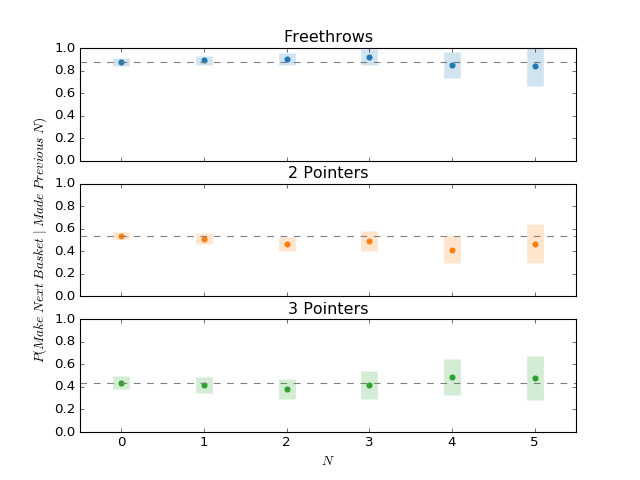

In [18]:
fig, axes = plt.subplots(3, sharex=True, figsize=(8, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['Freethrows', '2 Pointers', '3 Pointers']
data = [y1, y2, y3]
for i in range(len(data)):
    axes[i].hlines(data[i][0][0], min(x)-0.5, max(x)+0.5, linestyle='--', color='gray', label='Expected')
    axes[i].scatter(x, [k[0] for k in data[i]], color=colors[i], label=labels[i])
    
    for n, (mu, int_95) in zip(x, data[i]):
        axes[i].vlines(n, mu - int_95, mu + int_95, color=colors[i], linewidth=15, alpha=0.2)
    
    axes[i].set_title(labels[i])
    axes[i].set_ybound([0, 1])
    axes[i].set_xbound([min(x)-0.5, max(x)+0.5])

axes[1].set_ylabel(r"$P(Make\ Next\ Basket\ |\ Made\ Previous\ N)$")
axes[-1].set_xlabel(r"$N$")
pass

No statistically significant hot hand effect for Kawhi Leonard. Next step: per-player statistics for everyone on the Spurs

# Aggregate Hot-Hand for all Spurs

In [19]:
x = range(6)
all_P = [dict((i, [0, 0]) for i in [1, 2, 3]) for _ in x]
for player in spurs.scoring_record:
    for n in x:
        P = makes_misses(spurs, player, n_prev=n)#, compare_alike=True)
        for key in [1, 2, 3]:
            all_P[n][key][0] += P[key][0]
            all_P[n][key][1] += P[key][1]

<IPython.core.display.Javascript object>


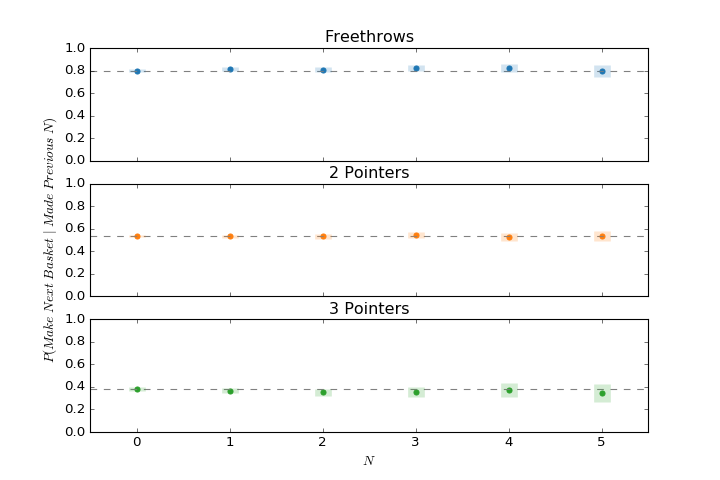

In [20]:
y1 = [mean_int(*p[1]) for p in all_P]
y2 = [mean_int(*p[2]) for p in all_P]
y3 = [mean_int(*p[3]) for p in all_P]
data = [y1, y2, y3]

fig, axes = plt.subplots(3, sharex=True, figsize=(9, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['Freethrows', '2 Pointers', '3 Pointers']
data = [y1, y2, y3]
for i in range(len(data)):
    axes[i].hlines(data[i][0][0], min(x)-0.5, max(x)+0.5, linestyle='--', color='gray', label='Expected')
    axes[i].scatter(x, [k[0] for k in data[i]], color=colors[i], label=labels[i])
    
    for n, (mu, int_95) in zip(x, data[i]):
        axes[i].vlines(n, mu - int_95, mu + int_95, color=colors[i], linewidth=15, alpha=0.2)
    
    axes[i].set_title(labels[i])
    axes[i].set_ybound([0, 1])
    axes[i].set_xbound([min(x)-0.5, max(x)+0.5])

axes[1].set_ylabel(r"$P(Make\ Next\ Basket\ |\ Made\ Previous\ N)$")
axes[-1].set_xlabel(r"$N$")
pass

# Fuzzy Hot Handedness

In [21]:
def fuzzy_plotting_data(p_dict):
    plotting_data = dict()
    for i in [1, 2, 3]:
        temp_data = [mean_int(*mm) for mm in p_dict[i]]
        plotting_data[i] = [(j, temp_data[j]) for j in range(len(p_dict[i]))
                            if temp_data[j] is not None]
    return plotting_data

player = 'Kawhi Leonard'
team = spurs
#P = fuzzy_makes_misses(team, player, n_prev=5, compare_alike=True)
P = fuzzy_makes_misses(team, player, n_prev=10)
data = fuzzy_plotting_data(P)

<IPython.core.display.Javascript object>


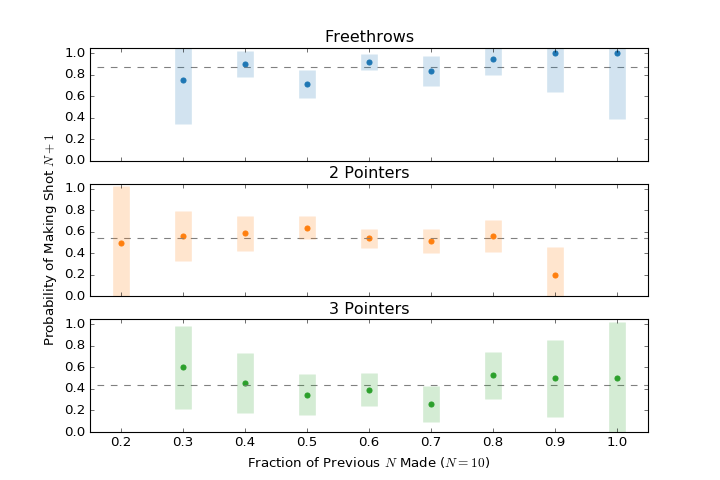

In [22]:
fig, axes = plt.subplots(3, sharex=True, figsize=(9, 6))

baselines = player_breakdown(team, player)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['Freethrows', '2 Pointers', '3 Pointers']
N = 10
min_prob = 1
for i, shot_type, c, label in zip(range(3), range(1, 4), colors, labels):
    x, y_tups = zip(*data[shot_type])
    x = [j/N for j in x]
    if min(x) < min_prob:
        min_prob = min(x)
    axes[i].scatter(x, [j[0] for j in y_tups], color=c)
    axes[i].hlines(baselines[shot_type][0]/sum(baselines[shot_type]), -1, 2, linestyle='--', color='gray')
    axes[i].set_title(label)
    
    for n, (mu, int_95) in zip(x, y_tups):
        axes[i].vlines(n, mu - int_95, mu + int_95, color=c, linewidth=15, alpha=0.2)
  
    axes[i].set_ybound([0, 1.05])
    
axes[i].set_xticks([i/N for i in range(N+1)])
axes[i].set_xbound([min_prob-0.05, 1.05])
axes[1].set_ylabel("Probability of Making Shot $N+1$")
axes[i].set_xlabel("Fraction of Previous $N$ Made ($N={}$)".format(N))